In [34]:
# Import necessary library needed for the model training
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
import tensorflow as tf
py.init_notebook_mode(connected=True)
%matplotlib inline
# Read the data set
data = pd.read_csv("C:/Users/waghm/Desktop/D1.csv", index_col="Timestamp")
# View data info
data.info()

# View data rows
data.head()

# Check latest date of data
data.tail()

# Plot line graph base on Weighted Price
btc_trace=go.Scatter(x=data.index, y=data['Weighted_Price'], name='Price')
py.iplot([btc_trace])

# Fill value 0 data points on Weighted Price with NaN and then use ffill method to fill values
data['Weighted_Price'].replace(0, np.nan, inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)


# Plot new line graph again on Weighted Price with newly filled values
btc_trace = go.Scatter(x=data.index, y=data['Weighted_Price'], name='Price')
py.iplot([btc_trace])

# Using Weighted Price as a feature to train the LSTM model
# Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
values = data['Weighted_Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Split 70% of data for training and 30% for testing
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))


# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

# Generate dataset for trainX, trainY, testX, testY
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape X for model training
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX)

config = tf.ConfigProto()
config.intra_op_parallelism_threads = 44
config.inter_op_parallelism_threads = 44
tf.Session(config=config)

<class 'pandas.core.frame.DataFrame'>
Index: 10766 entries, 1/01/2017 10:00 to 25/03/2018 23:00
Data columns (total 7 columns):
Open                 10766 non-null float64
High                 10766 non-null float64
Low                  10766 non-null float64
Close                10766 non-null float64
Volume_(BTC)         10766 non-null float64
Volume_(Currency)    10766 non-null float64
Weighted_Price       10766 non-null float64
dtypes: float64(7)
memory usage: 672.9+ KB


7536 3230
7535
3229
[[[0.01073854]]

 [[0.01076298]]

 [[0.01082985]]

 ...

 [[0.3207208 ]]

 [[0.3107811 ]]

 [[0.30964893]]]


In [33]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

# Drop unnecessary columns
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

IndexError: index 8 is out of bounds for axis 0 with size 6

In [4]:
#  avoid logging error
#  tf.logging.set_verbosity(tf.logging.ERROR)

# Running LSTM model with 300 epochs

model = Sequential()


In [5]:
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.add(Dense(1))

In [8]:

model.compile(loss='mae', optimizer='adam')

In [9]:

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

Instructions for updating:
Use tf.cast instead.


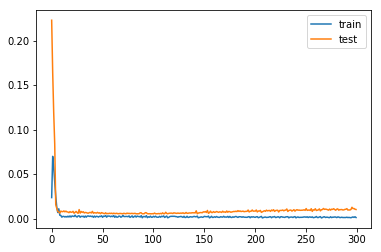

In [11]:
# Plot line graph to show amount loss according to the epoch
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

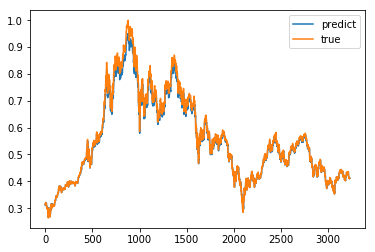

In [12]:
# Make prediction using textX and plotting line graph against testY
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [13]:
# Scaler Inverse Y back to normal value
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [14]:
# RMSE
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 284.996


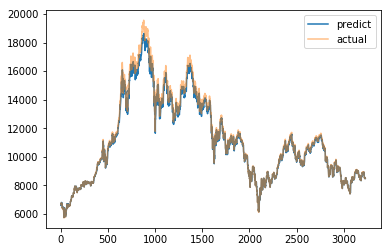

In [16]:
# Plot line graph with Y as USD
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [17]:
# Convert X to dates
predictDates = data.tail(len(testX)).index

In [18]:
# Reshape testY and yhat for plotly
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [19]:
# Plot predicted and actual line graph with X=dates, Y=USD
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name='Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name='Predict Price')
py.iplot([predict_chart, actual_chart])

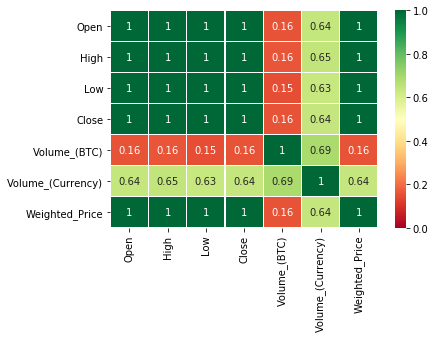

In [20]:
# Using additional features for model training
# Find correlation in features to Weighted Price
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [21]:
# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0 , -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
            

In [22]:
# Get all data values
values = data[['Weighted_Price'] + ['Volume_(BTC)'] + ['Volume_(Currency)']].values
values = values.astype('float32')
# Normalise features to range from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [23]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.010739,0.005638,0.000960,0.010763,0.012766,0.002178
2,0.010763,0.012766,0.002178,0.010830,0.012496,0.002136
3,0.010830,0.012496,0.002136,0.010917,0.007631,0.001305
4,0.010917,0.007631,0.001305,0.010811,0.005765,0.001857
5,0.010811,0.005765,0.001857,0.010807,0.006867,0.001175


In [24]:
# Drop unnecessary columns
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.010739   0.005638   0.000960  0.010763
2   0.010763   0.012766   0.002178  0.010830
3   0.010830   0.012496   0.002136  0.010917
4   0.010917   0.007631   0.001305  0.010811
5   0.010811   0.005765   0.001857  0.010807


In [25]:
# Split data to 70% training, 30% testing
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7535, 1, 3) (7535,) (3230, 1, 3) (3230,)


In [26]:
# Training the LSTM with 300 epochs
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

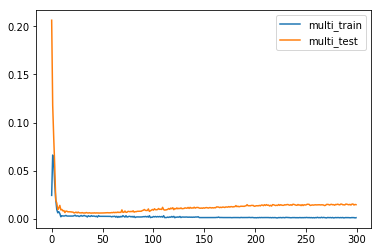

In [27]:
# Plot line graph to show amount loss according to the epoch
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

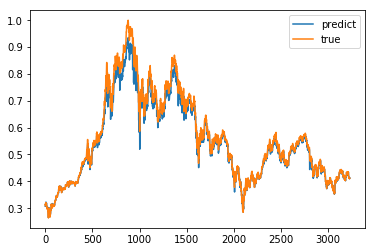

In [28]:
# Make prediction using testX and plotting the graph against testY
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [29]:
# Sclaer Inverse Y back to normal value
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [30]:
# RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 418.751


In [32]:
# Plot line graph with actual price, predicted price with feature weightedprice, redicted price with features Volume and weightedprice
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])